In [1]:
from math import sqrt
import os
import glob

from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import lstm2
import numpy as np
# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


# Introduction

This notebook is to read SP500 stocks trained for 30 day predictions and visualize the top results

In [2]:
config_file = '../config/sp500.config'
source_dir, models_dir, supervised_data_dir, prediction_data_dir, rmse_csv,n_lags, n_forecast, n_test = lstm2.read_config(config_file)

('../data/sp500_1', '../models/sp500_30', '../data/sp500_sup_30', '../data/sp500_pred_30', '../data/rsme_sp500.csv')
('n_lags, n_forecast, n_test', 5, 30, 90)


In [3]:
def plot_data(rmse_df, predicted_dfs):
    cnt = 1
    for index, row in rmse_df.iterrows():
        key = row['Stock Model']
        if (cnt % 2 != 0):
            fig, axes = plt.subplots(nrows=1, ncols=2)
            ax=axes[0]
        else:
            ax=axes[1]
        predicted_dfs[key].plot(title=key + ': n_forecast = ' + str(n_forecast) +
                                ', n_lags = ' + str(n_lags) + ': price vs days', 
                                figsize=(15,4), 
                                ax=ax)
        cnt += 1
    plt.show()

# Visualize Results

In [4]:
# Look at data from SP500
predicted_dfs, summary_df = lstm2.read_prediction_files('../data/sp500_pred_30')
#top_stocks = summary_df.head(10)
day0_pred_stocks = summary_df.loc[summary_df['Day 0 predicted gain'] > 0.1]
day0_pred_stocks

,Stock Model,rsme,Day 0 predicted gain,Day 0 actual gain,Avg predicted gain,Avg actual gain
92,CHK,1.587095,0.148363,-0.101942,0.198252,-0.107875
286,LRCX,19.341690,0.115836,0.201604,0.151459,0.055359
259,JNPR,4.888602,0.168044,0.055775,0.144041,-0.019688
7,ADBE,11.668089,0.117641,0.085956,0.119672,0.042529
240,IDXX,21.198613,0.102888,0.064064,0.109214,-0.011227
440,TRIP,6.956783,0.115560,-0.015682,0.103815,-0.011842
173,EW,11.852812,0.112363,0.219979,0.093714,0.017739
388,RCL,7.175540,0.110873,0.135152,0.090201,0.052537


In [5]:
day0_actual_stocks = summary_df.loc[summary_df['Day 0 actual gain'] > 0.1].sort_values(
    by='Day 0 actual gain', ascending=False)
day0_actual_stocks.head(10)

,Stock Model,rsme,Day 0 predicted gain,Day 0 actual gain,Avg predicted gain,Avg actual gain
343,NVDA,23.053700,0.040533,0.413738,0.033711,0.139207
11,ADSK,9.926948,0.015907,0.308059,0.016510,0.062215
153,EA,11.213494,-0.003181,0.252342,-0.008994,0.063424
389,REGN,50.300635,0.099819,0.248372,0.048142,0.037567
63,BCR,20.363223,0.047915,0.234866,0.054178,0.030860
173,EW,11.852812,0.112363,0.219979,0.093714,0.017739
25,ALGN,15.085875,0.030177,0.206177,0.025798,0.115845
286,LRCX,19.341690,0.115836,0.201604,0.151459,0.055359
384,PYPL,5.507819,0.022718,0.195830,0.080898,0.094961
322,MTD,45.519675,0.014869,0.195421,0.004589,0.051743


In [6]:
top_avg_pred = summary_df.loc[summary_df['Avg predicted gain'] > 0.1].sort_values(
                            by='Avg predicted gain', ascending=False)
top_avg_pred

,Stock Model,rsme,Day 0 predicted gain,Day 0 actual gain,Avg predicted gain,Avg actual gain
92,CHK,1.587095,0.148363,-0.101942,0.198252,-0.107875
286,LRCX,19.341690,0.115836,0.201604,0.151459,0.055359
259,JNPR,4.888602,0.168044,0.055775,0.144041,-0.019688
7,ADBE,11.668089,0.117641,0.085956,0.119672,0.042529
275,LB,10.637102,0.088104,0.033994,0.114421,-0.073494
240,IDXX,21.198613,0.102888,0.064064,0.109214,-0.011227
440,TRIP,6.956783,0.115560,-0.015682,0.103815,-0.011842
180,FCX,1.559459,0.083281,-0.126285,0.101779,0.061117
145,DRI,11.113713,0.096213,0.051483,0.100235,-0.012116


In [7]:
top_avg_actual = summary_df.loc[summary_df['Avg actual gain'] > 0.1].sort_values(
                            by='Avg actual gain', ascending=False)
top_avg_actual

,Stock Model,rsme,Day 0 predicted gain,Day 0 actual gain,Avg predicted gain,Avg actual gain
338,NRG,5.095335,-0.042450,-0.102664,-0.048018,0.144499
343,NVDA,23.053700,0.040533,0.413738,0.033711,0.139207
25,ALGN,15.085875,0.030177,0.206177,0.025798,0.115845
60,BA,20.299808,0.024211,0.045350,0.024960,0.108474


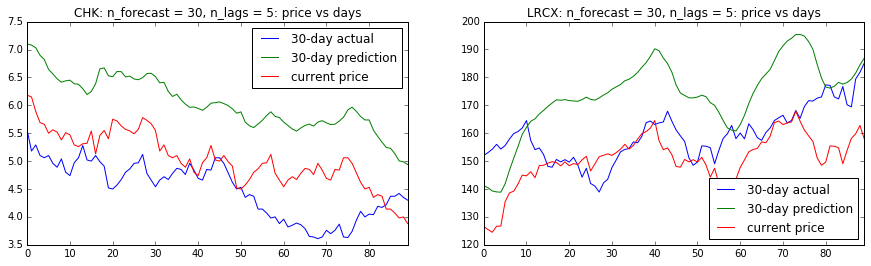

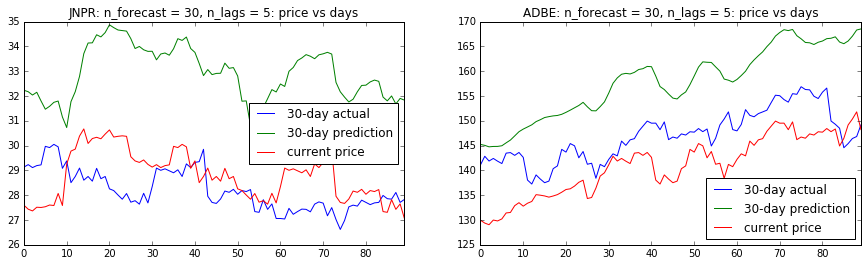

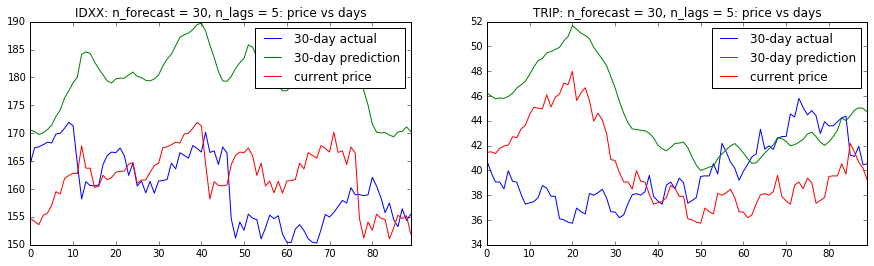

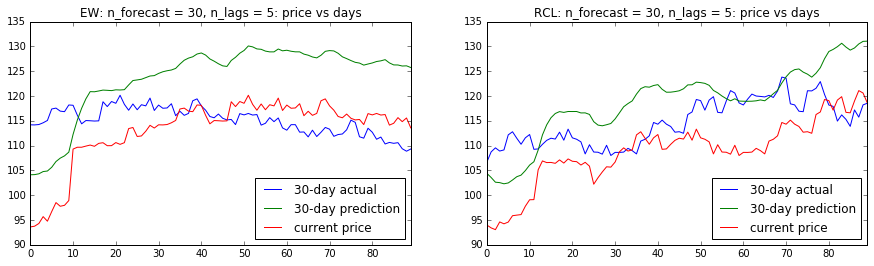

In [8]:
# Plot based on top 1st day prediction prices
plot_data(day0_pred_stocks, predicted_dfs)

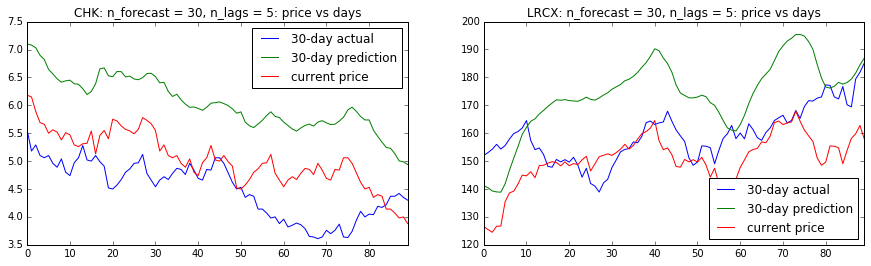

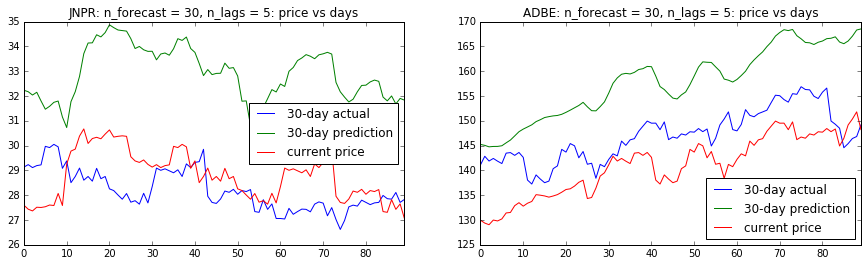

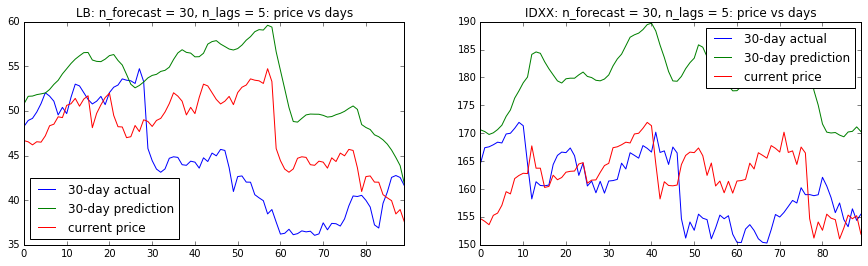

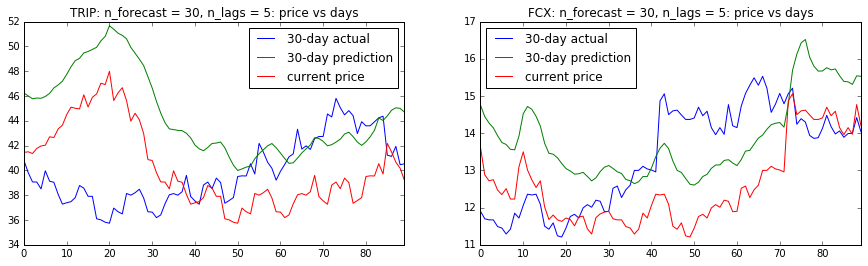

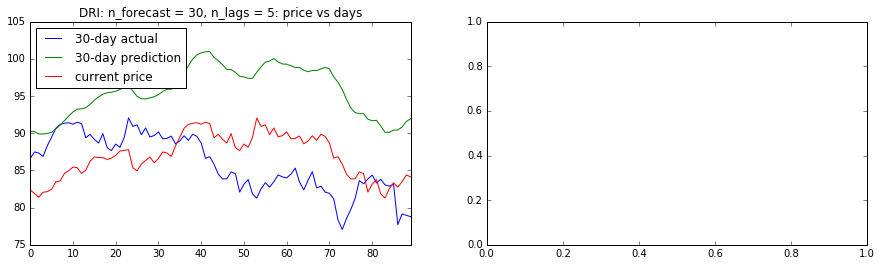

In [9]:
# Plot based on top avg prediction prices
plot_data(top_avg_pred, predicted_dfs)